<hr style="border-width:2px;border-color:#75DFC1">
<h1 style = "text-align:center">Time Series Forecasting</h1>
<h2 style = "text-align:center">Univariate time series - Complex study case (no straightforward seasonality/cyclic behaviour, missing dates) - Stock market prediction </h2>

<h2 style = "text-align:center">LSTM</h2>
<h4 style = "text-align:center">Didier Law-Hine</h4>
<h4 style = "text-align:center">August 2022</h4>

<hr style="border-width:2px;border-color:#75DFC1">

In this notebook, the dataset consists of records about the stock price of Tata Global Beverages Limited. The dataset also contains a date-wise price of stock with open, close, high, and low prices along with volume traded as well as turnover on that day.

For LSTM model, I consider the following important parameters to be tuned :
- the number of lag $n$ to account for the prediction of  $y_t$ :  $y_{t-1},y_{t-2}, ... , y_{t-n}$. In this notebook, you will see $n$=30.
- number of hidden layers and units in each layer. Here, I chose 1 layer of 50 units.
- epochs and batch size. Here, typically epochs=80, batch size=20

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from math import sqrt
from numpy import concatenate
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,8

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
import statsmodels.graphics.tsaplots as smgt

from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense

from pmdarima.arima import auto_arima
from sktime.forecasting.arima import AutoARIMA

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  1235 non-null   datetime64[ns]
 1   Open                  1235 non-null   float64       
 2   High                  1235 non-null   float64       
 3   Low                   1235 non-null   float64       
 4   Last                  1235 non-null   float64       
 5   Close                 1235 non-null   float64       
 6   Total Trade Quantity  1235 non-null   float64       
 7   Turnover (Lacs)       1235 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 77.3 KB


None

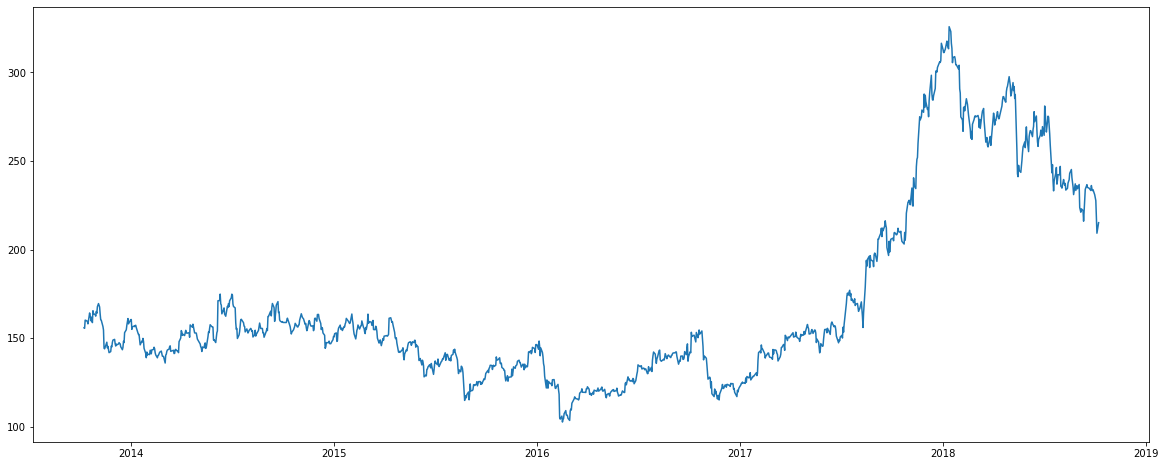

In [22]:
# Load dataset
df = pd.read_csv("NSE-Tata-Global-Beverages-Limited.csv")
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
display(df.head())
display(df.info())
# Dataviz
fig,ax1=plt.subplots()
ax1=plt.plot(df["Date"],df["Close"],label='Close Price history')

In [23]:
# Selecting the time series from the initial dataframe 
df2=df.sort_values(by=["Date"],ascending=True,axis=0).reset_index(drop=True)
df3=pd.DataFrame(index=range(0,len(df2)),columns=['Date','Close'])
for i in range(0,len(df3)):
    df3["Date"][i]=df2['Date'][i]
    df3["Close"][i]=df2["Close"][i]   
df3.index=df3.Date
df3.drop("Date",axis=1,inplace=True)

# Resampling
df3=df3.asfreq(freq='D') # This will add rows so that frequency is equal to 1 day. But this will generate NaNs
display(df3.head(10))
display(df3.shape)
# Filling NaNs with interpolating
#https://towardsdatascience.com/4-techniques-to-handle-missing-values-in-time-series-data-c3568589b5a8
df4=df3.astype('float')
df4['Close'].interpolate(inplace=True,limit_direction='forward', axis=0) #default is linear interpolating
display(df4.head(10))
display(df4.shape)


,Close
Date,
2013-10-08,155.8
2013-10-09,155.55
2013-10-10,160.15
2013-10-11,160.05
2013-10-12,NaN
2013-10-13,NaN
2013-10-14,159.45
2013-10-15,158.05
2013-10-16,NaN


(1827, 1)

,Close
Date,
2013-10-08,155.800
2013-10-09,155.550
2013-10-10,160.150
2013-10-11,160.050
2013-10-12,159.850
2013-10-13,159.650
2013-10-14,159.450
2013-10-15,158.050
2013-10-16,160.025


(1827, 1)

In [ ]:
## Preparing data for LSTM
# Convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Selecting the time series from the initial dataframe --> called 'values' (np.array)
df2=df.sort_values(by=["Date"],ascending=True,axis=0).reset_index(drop=True)
display(df2.head())
df3=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])
for i in range(0,len(df3)):
    df3["Date"][i]=df2['Date'][i]
    df3["Close"][i]=df2["Close"][i]   
df3.index=df3.Date
df3.drop("Date",axis=1,inplace=True)
values=df3.values
display(values.shape)
# integer encode direction
##encoder = LabelEncoder()
##values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_days = 30
n_features = 1
# frame as supervised learning
reframed = series_to_supervised(scaled, n_days, 1)
print(reframed.head())
print(reframed.shape)

# split into train and test sets
values = reframed.values
n_train_days = 987
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
n_obs = n_days * n_features
X_train, y_train = train[:, :n_obs], train[:, -n_features]
X_test, y_test = test[:, :n_obs], test[:, -n_features]
print(X_train.shape, len(X_train), y_train.shape)
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], n_days, n_features))
X_test = X_test.reshape((X_test.shape[0], n_days, n_features))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

In [ ]:
df3=df3.astype(float)

In [ ]:
## Model : LSTM(50),Dense(1)
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(X_train, y_train, epochs=80, batch_size=20, validation_data=(X_test, y_test), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
# Make a prediction
yhat = model.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, X_test[:, - n_features -1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
y_test = y_test.reshape((len(y_test), 1))
inv_y = concatenate((y_test, X_test[:, - n_features -1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

# Plot prediction
df_values=df3.Close
d = {'train': df_values, 'test': pd.Series(inv_yhat, index=df_values.index[np.arange(n_train_days+n_days,len(df_values))])}
df_plot=pd.DataFrame(data=d, index=df3.index)
plt.figure();
plt.plot(df_plot);


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
res = seasonal_decompose(df3,period=12)
res.plot()
plt.show()

In [ ]:
from statsmodels.tsa.seasonal import STL

stl = STL(df3,period=13, robust=True)
res = stl.fit()
fig = res.plot()

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7)):
    """
        Plot time series, its ACF and PACF, calculate ADF and KPSS tests
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
           
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value_ADF = sm.tsa.stattools.adfuller(y)[1]
    p_value_KPSS = sm.tsa.stattools.kpss(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f} \n KPSS: p={1:.5f}'.format(p_value_ADF,p_value_KPSS))
    sm.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax)
    sm.graphics.tsa.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

    
# Selecting the time series from the initial dataframe 
df2=df.sort_values(by=["Date"],ascending=True,axis=0).reset_index(drop=True)
display(df2.head())
df3=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])
for i in range(0,len(df3)):
    df3["Date"][i]=df2['Date'][i]
    df3["Close"][i]=df2["Close"][i]   
df3.index=df3.Date
df3.drop("Date",axis=1,inplace=True)
display(df3.head())
tsplot(df3["Close"])

In [ ]:
ts_diff = (df3["Close"] - df3["Close"].shift(1)).dropna()
tsplot(ts_diff)

In [ ]:
model=sm.tsa.SARIMAX(df3[0:987].astype(float),order=(1,1,0),seasonal_order=(0,1,0,12))
arima=model.fit()
print(arima.summary())

In [ ]:
import datetime
t1 = datetime.date(2018,10,5)
t2 = datetime.date(2018,10,8)
pred = arima.predict(t1,t2)
concatpred = pd.concat([df3, pred])#Concaténation des prédictions

plt.plot(concatpred) #Visualisation


In [ ]:
print(t1)
print(df3.iloc[1234])

In [ ]:
pred

In [ ]:
df3.tail()

In [ ]:
from pmdarima.arima import auto_arima
train=df3[0:987].astype(float)
valid=df3[988:1235].astype(float)
model = auto_arima(y=train, error_action='ignore', suppress_warnings=True)
model.fit(train)
display(model.summary())
forecast = model.predict(n_periods=len(valid))
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

#plot the predictions for validation set
plt.plot(train, label='Train')
plt.plot(valid, label='Valid')
plt.plot(forecast, label='Prediction')
plt.show()

In [ ]:
from sktime.forecasting.arima import AutoARIMA
train=df3[0:987]
test=df3[988:1234]
forecaster = AutoARIMA(start_p=0,max_p=2, error_action='ignore', suppress_warnings=True)                                      
train = train.astype(float)
forecaster.fit(train)


In [ ]:

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error


def plot_forecast(series_train, series_test, forecast, forecast_int=None):

    mae = mean_absolute_error(series_test, forecast)
    mape = mean_absolute_percentage_error(series_test, forecast)

    plt.figure(figsize=(12, 6))
    plt.title(f"MAE: {mae:.2f}, MAPE: {mape:.3f}", size=18)
    series_train.plot(label="train", color="b")
    series_test.plot(label="test", color="g")
    forecast.index = series_test.index
    forecast.plot(label="forecast", color="r")
    if forecast_int is not None:
        plt.fill_between(
            series_test.index,
            forecast_int["lower"],
            forecast_int["upper"],
            alpha=0.2,
            color="dimgray",
        )
    plt.legend(prop={"size": 16})
    plt.show()

    return mae, mape

fh = np.arange(len(test)) + 1
forecast, forecast_int = forecaster.predict(fh=fh)
sun_arima_mae, sun_arima_mape = plot_forecast(
    train, test, forecast, forecast_int
)